## Fase 4: Estrategia de cobertura como control (Hedging como ley de control)

La cobertura dinámica se interpreta como un feedback proporcional donde la señal de control  
$$
u(t)=\Delta(t)=\frac{\partial V}{\partial S}(S(t),t)
$$  
ajusta la posición en el subyacente para anular el término estocástico $\sigma S\,dB(t)$ en el portafolio replicante:  
$$
\Pi(t)=-V(S(t),t)+\Delta(t)\,S(t).
$$  
Al aplicar la fórmula de Itô y sustituir $\Delta=V_S$, se comprueba que $d\Pi= r\Pi\,dt$ y se recupera la PDE de Black–Scholes.

In [1]:
# Cálculo numérico de V, Delta y Pi
import numpy as np
from scipy.stats import norm

# Parámetros
S0 = 100      # precio inicial
K  = 100      # strike
r  = 0.05     # tasa libre de riesgo
sigma = 0.2   # volatilidad
T  = 1.0      # vencimiento (años)
t  = 0.5      # tiempo actual (años)
tau = T - t   # tiempo hasta vencimiento

# Fórmulas de Black–Scholes para call europea
def bs_price_call(S, K, r, sigma, tau):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)

def bs_delta_call(S, K, r, sigma, tau):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    return norm.cdf(d1)

# Cálculo
V     = bs_price_call(S0, K, r, sigma, tau)
Delta = bs_delta_call(S0, K, r, sigma, tau)
Pi    = -V + Delta*S0

print(f"Precio de la opción V = {V:.4f}")
print(f"Delta = {Delta:.4f}")
print(f"Portafolio replicante Π = {Pi:.4f}")

Precio de la opción V = 6.8887
Delta = 0.5977
Portafolio replicante Π = 52.8847


### Derivación de la dinámica del portafolio con la fórmula de Itô

Consideramos el portafolio  
$$
\Pi = V(t,S) - \Delta(t,S)\,S
$$  
y utilizamos  
$$
dV = V_t\,dt + V_S\,dS + \tfrac12 V_{SS}(dS)^2,
\quad
dS = \mu S\,dt + \sigma S\,dW.
$$  
Por tanto,  
$$
dV = \bigl(V_t + \mu S\,V_S + \tfrac12\sigma^2 S^2\,V_{SS}\bigr)\,dt
     + \sigma S\,V_S\,dW.
$$  
La variación del portafolio es  
$$
d\Pi = dV - \Delta\,dS.
$$  
Eligiendo  
$$
\Delta = V_S
$$  
se elimina el término en $dW$, y queda  
$$
d\Pi = \bigl(V_t + \tfrac12\sigma^2 S^2\,V_{SS}\bigr)\,dt.
$$

### Derivación de la ecuación de Black–Scholes–Merton

Para que el portafolio sea libre de riesgo, su rendimiento debe ser la tasa libre de riesgo $r$:  
$$
d\Pi = r\,\Pi\,dt = r\bigl(V - V_S\,S\bigr)\,dt.
$$  
Igualando los drifts:  
$$
V_t + \tfrac12\sigma^2 S^2\,V_{SS}
= rV - rS\,V_S.
$$  
Reordenando obtenemos la PDE de Black–Scholes–Merton:  
$$
V_t + \tfrac12\sigma^2 S^2\,V_{SS} + rS\,V_S - rV = 0.
$$

## Ley de control y análisis de estabilidad

En términos de control:
- **Variable de estado**: $S(t)$  
- **Output**: $V(S,t)$  
- **Ley proporcional**: $u(t)=\Delta=V_S$

Para estudiar la estabilidad, linealizamos alrededor de un punto de operación $(S_0,V_0)$ definiendo:
$$
S(t) = S_0 + \delta S(t),
\quad
V(S(t),t) = V_0 + \delta V(t).
$$  
Se obtiene la ecuación linealizada:
$$
\dot{\delta V} = -r\,\delta V - K\,\delta S,
\quad
K := A_1 + A_2.
$$  
donde
$$
A_1 = \tfrac12\sigma^2\bigl(2S_0\beta_0 + S_0^2\gamma_0\bigr),
\quad
A_2 = \mu\bigl(\Delta_0 + S_0\beta_0\bigr).
$$

/usr/local/lib/python3.11/dist-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


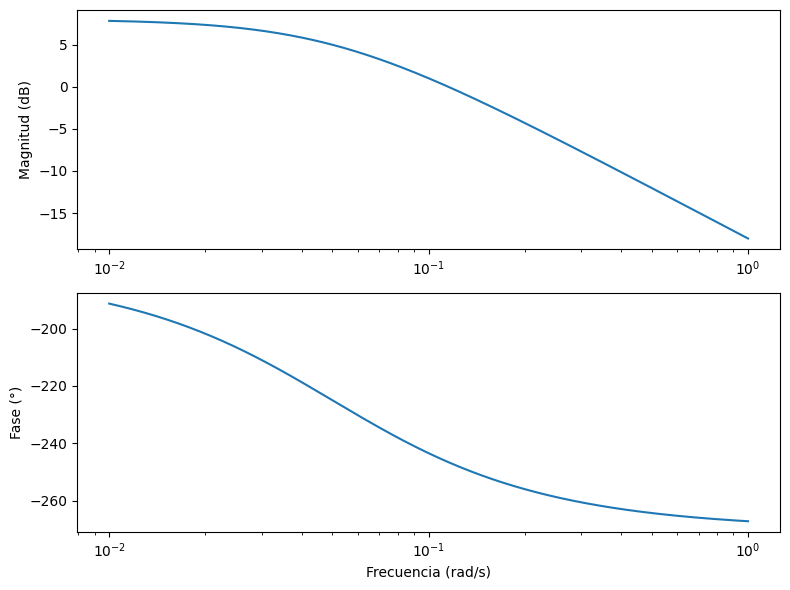

In [7]:
import numpy as np
from scipy.stats import norm
import control as ctrl
import matplotlib.pyplot as plt

# Parámetros (reusar S0, K_strike, r, sigma, mu, tau definidos previamente)
# Cálculo de beta0 (Gamma) y gamma0 (tercera derivada)
def bs_gamma_call(S, K, r, sigma, tau):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    return norm.pdf(d1) / (S * sigma * np.sqrt(tau))

beta0 = bs_gamma_call(S0, K_strike, r, sigma, tau)
h = 1e-4
beta_plus  = bs_gamma_call(S0 + h, K_strike, r, sigma, tau)
beta_minus = bs_gamma_call(S0 - h, K_strike, r, sigma, tau)
gamma0 = (beta_plus - beta_minus) / (2*h)

Delta0 = bs_delta_call(S0, K_strike, r, sigma, tau)

A1 = 0.5 * sigma**2 * (2*S0*beta0 + S0**2*gamma0)
A2 = mu * (Delta0 + S0*beta0)
K  = A1 + A2

# Definimos la función de transferencia G(s) = -K/(s + r)
G = ctrl.TransferFunction([-K], [1, r])

# Diagrama de Bode sin plotting automático (plot=False)
mag, phase, omega = ctrl.bode(G, dB=True, plot=False)

plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.semilogx(omega, 20 * np.log10(mag))
plt.ylabel('Magnitud (dB)')

plt.subplot(2,1,2)
plt.semilogx(omega, phase * 180/np.pi)
plt.ylabel('Fase (°)')
plt.xlabel('Frecuencia (rad/s)')

plt.tight_layout()
plt.show()